In [1]:
from ModelTransfuser.ModelTransfuser import *
from ModelTransfuser.simformer import *
import matplotlib.pyplot as plt
import matplotlib.animation
import matplotlib.patches as patches
import seaborn as sns

import numpy as np
import torch
import pandas as pd

from scipy.stats import norm

import os

%matplotlib inline

In [2]:
def gen_data(int):
    theta1 = torch.randn(int) * 3
    x1 = 2 * torch.sin(theta1) + torch.randn(int) * 0.5
    x2 = 0.1 * theta1**2 + 0.5*torch.abs(x1) * torch.randn(int)

    return torch.stack([theta1, x1, x2])

In [3]:
data = gen_data(1000)
val_data = gen_data(1000)
nodes_max = data.shape[0]
node_ids = torch.arange(nodes_max)

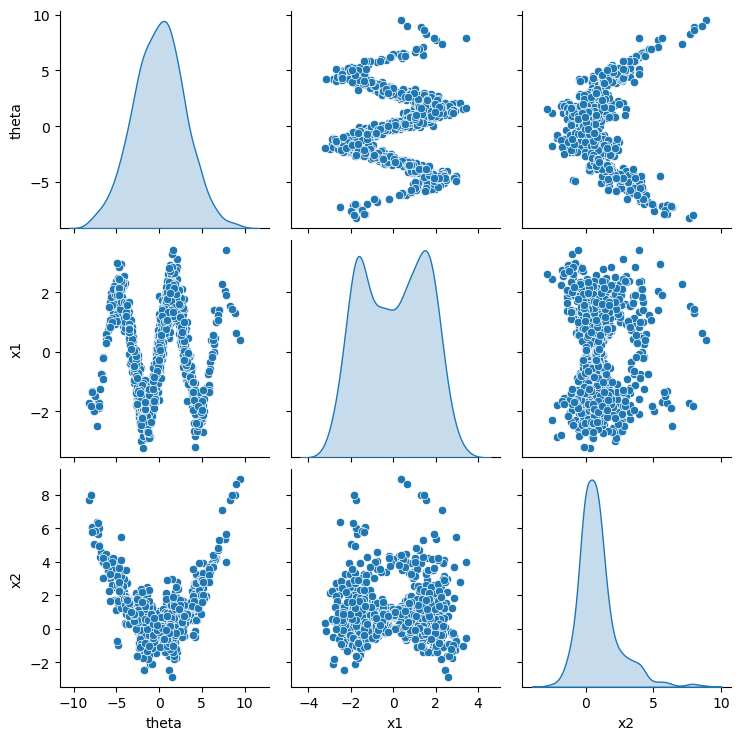

In [4]:
df = pd.DataFrame(data.T.numpy(), columns=['theta', 'x1', 'x2'])
sns.pairplot(df, diag_kind='kde')
plt.show()

In [5]:
data.T.shape

torch.Size([1000, 3])

In [6]:
model = ModelTransfuser(data.T.shape[1])

In [7]:
model.train(data.T, val_data=val_data.T, epochs=1000, device="cuda:7")

Epoch  1/1000: 100%|██████████| 16/16 [00:00<00:00, 19.33it/s]


--- Training Loss:   19761.978 --- Validation Loss:   18530.477 ---



Epoch  2/1000: 100%|██████████| 16/16 [00:00<00:00, 37.61it/s]


--- Training Loss:   17488.562 --- Validation Loss:   16012.057 ---



Epoch  3/1000: 100%|██████████| 16/16 [00:00<00:00, 38.07it/s]


--- Training Loss:   15710.877 --- Validation Loss:   17160.773 ---



Epoch  4/1000: 100%|██████████| 16/16 [00:00<00:00, 38.56it/s]


--- Training Loss:   15627.619 --- Validation Loss:   16137.241 ---



Epoch  5/1000: 100%|██████████| 16/16 [00:00<00:00, 37.46it/s]


--- Training Loss:   16186.317 --- Validation Loss:   14410.185 ---



Epoch  6/1000: 100%|██████████| 16/16 [00:00<00:00, 36.22it/s]


--- Training Loss:   14931.487 --- Validation Loss:   14191.200 ---



Epoch  7/1000: 100%|██████████| 16/16 [00:00<00:00, 36.25it/s]


--- Training Loss:   15688.247 --- Validation Loss:   17213.213 ---



Epoch  8/1000: 100%|██████████| 16/16 [00:00<00:00, 38.62it/s]


--- Training Loss:   14173.401 --- Validation Loss:   15014.011 ---



Epoch  9/1000: 100%|██████████| 16/16 [00:00<00:00, 36.18it/s]


--- Training Loss:   14710.520 --- Validation Loss:   16195.532 ---



Epoch 10/1000: 100%|██████████| 16/16 [00:00<00:00, 38.29it/s]


--- Training Loss:   15500.093 --- Validation Loss:   15416.302 ---



Epoch 11/1000: 100%|██████████| 16/16 [00:00<00:00, 38.66it/s]


--- Training Loss:   14234.051 --- Validation Loss:   15964.914 ---



Epoch 12/1000: 100%|██████████| 16/16 [00:00<00:00, 38.00it/s]


--- Training Loss:   16563.951 --- Validation Loss:   15832.354 ---



Epoch 13/1000: 100%|██████████| 16/16 [00:00<00:00, 39.22it/s]


--- Training Loss:   14146.105 --- Validation Loss:   17623.088 ---



Epoch 14/1000: 100%|██████████| 16/16 [00:00<00:00, 39.89it/s]


--- Training Loss:   14075.956 --- Validation Loss:   15691.320 ---



Epoch 15/1000: 100%|██████████| 16/16 [00:00<00:00, 36.88it/s]


--- Training Loss:   15085.466 --- Validation Loss:   14851.704 ---



Epoch 16/1000: 100%|██████████| 16/16 [00:00<00:00, 38.33it/s]


--- Training Loss:   14363.267 --- Validation Loss:   15154.318 ---



Epoch 17/1000: 100%|██████████| 16/16 [00:00<00:00, 38.34it/s]


--- Training Loss:   14452.347 --- Validation Loss:   15039.031 ---



Epoch 18/1000: 100%|██████████| 16/16 [00:00<00:00, 39.05it/s]


--- Training Loss:   13875.060 --- Validation Loss:   15478.209 ---



Epoch 19/1000: 100%|██████████| 16/16 [00:00<00:00, 38.71it/s]


--- Training Loss:   15090.813 --- Validation Loss:   18492.420 ---



Epoch 20/1000: 100%|██████████| 16/16 [00:00<00:00, 37.96it/s]


--- Training Loss:   21786.474 --- Validation Loss:   16849.238 ---



Epoch 21/1000: 100%|██████████| 16/16 [00:00<00:00, 39.72it/s]


--- Training Loss:   16491.765 --- Validation Loss:   20180.678 ---



Epoch 22/1000: 100%|██████████| 16/16 [00:00<00:00, 38.33it/s]


--- Training Loss:   19309.124 --- Validation Loss:   23792.246 ---



Epoch 23/1000: 100%|██████████| 16/16 [00:00<00:00, 38.61it/s]


--- Training Loss:   23872.738 --- Validation Loss:   27016.756 ---



Epoch 24/1000: 100%|██████████| 16/16 [00:00<00:00, 39.01it/s]


--- Training Loss:   26492.555 --- Validation Loss:   30734.281 ---



Epoch 25/1000: 100%|██████████| 16/16 [00:00<00:00, 38.28it/s]


--- Training Loss:   27735.796 --- Validation Loss:   24815.025 ---



Epoch 26/1000: 100%|██████████| 16/16 [00:00<00:00, 38.78it/s]


--- Training Loss:   24491.419 --- Validation Loss:   27935.838 ---



Epoch 27/1000: 100%|██████████| 16/16 [00:00<00:00, 38.34it/s]


--- Training Loss:   23824.373 --- Validation Loss:   27951.824 ---



Epoch 28/1000: 100%|██████████| 16/16 [00:00<00:00, 38.61it/s]


--- Training Loss:   24237.198 --- Validation Loss:   16439.297 ---



Epoch 29/1000: 100%|██████████| 16/16 [00:00<00:00, 39.24it/s]


--- Training Loss:   20039.947 --- Validation Loss:   20103.869 ---



Epoch 30/1000: 100%|██████████| 16/16 [00:00<00:00, 38.83it/s]


--- Training Loss:   21432.735 --- Validation Loss:   23132.191 ---



Epoch 31/1000: 100%|██████████| 16/16 [00:00<00:00, 39.98it/s]


--- Training Loss:   21137.533 --- Validation Loss:   19600.604 ---



Epoch 32/1000: 100%|██████████| 16/16 [00:00<00:00, 38.81it/s]


--- Training Loss:   16590.608 --- Validation Loss:   23229.602 ---



Epoch 33/1000: 100%|██████████| 16/16 [00:00<00:00, 38.33it/s]


--- Training Loss:   19031.843 --- Validation Loss:   18915.545 ---



Epoch 34/1000: 100%|██████████| 16/16 [00:00<00:00, 38.87it/s]


--- Training Loss:   16896.156 --- Validation Loss:   16192.195 ---



Epoch 35/1000: 100%|██████████| 16/16 [00:00<00:00, 39.46it/s]


--- Training Loss:   16513.562 --- Validation Loss:   15746.635 ---



Epoch 36/1000: 100%|██████████| 16/16 [00:00<00:00, 38.99it/s]


--- Training Loss:   16763.670 --- Validation Loss:   17995.865 ---



Epoch 37/1000: 100%|██████████| 16/16 [00:00<00:00, 39.71it/s]


--- Training Loss:   15486.495 --- Validation Loss:   16514.148 ---



Epoch 38/1000: 100%|██████████| 16/16 [00:00<00:00, 39.27it/s]


--- Training Loss:   16659.052 --- Validation Loss:   16265.896 ---



Epoch 39/1000: 100%|██████████| 16/16 [00:00<00:00, 38.47it/s]


--- Training Loss:   13708.386 --- Validation Loss:   17789.373 ---



Epoch 40/1000: 100%|██████████| 16/16 [00:00<00:00, 38.20it/s]


--- Training Loss:   16909.154 --- Validation Loss:   16525.873 ---



Epoch 41/1000: 100%|██████████| 16/16 [00:00<00:00, 38.89it/s]


--- Training Loss:   16989.946 --- Validation Loss:   17976.014 ---



Epoch 42/1000: 100%|██████████| 16/16 [00:00<00:00, 38.39it/s]


--- Training Loss:   18786.305 --- Validation Loss:   15797.588 ---



Epoch 43/1000: 100%|██████████| 16/16 [00:00<00:00, 38.88it/s]


--- Training Loss:   15721.078 --- Validation Loss:   14856.291 ---



Epoch 44/1000: 100%|██████████| 16/16 [00:00<00:00, 38.20it/s]


--- Training Loss:   15962.725 --- Validation Loss:   14788.505 ---



Epoch 45/1000: 100%|██████████| 16/16 [00:00<00:00, 37.38it/s]


--- Training Loss:   15456.526 --- Validation Loss:   17620.918 ---



Epoch 46/1000: 100%|██████████| 16/16 [00:00<00:00, 39.65it/s]


--- Training Loss:   16744.328 --- Validation Loss:   16023.353 ---



Epoch 47/1000: 100%|██████████| 16/16 [00:00<00:00, 39.13it/s]


--- Training Loss:   14693.917 --- Validation Loss:   13795.915 ---



Epoch 48/1000: 100%|██████████| 16/16 [00:00<00:00, 39.64it/s]


--- Training Loss:   16335.033 --- Validation Loss:   17167.264 ---



Epoch 49/1000: 100%|██████████| 16/16 [00:00<00:00, 39.58it/s]


--- Training Loss:   20153.580 --- Validation Loss:   18015.309 ---



Epoch 50/1000: 100%|██████████| 16/16 [00:00<00:00, 39.43it/s]


--- Training Loss:   18693.340 --- Validation Loss:   18887.914 ---



Epoch 51/1000: 100%|██████████| 16/16 [00:00<00:00, 39.67it/s]


--- Training Loss:   15189.143 --- Validation Loss:   17841.312 ---



Epoch 52/1000: 100%|██████████| 16/16 [00:00<00:00, 38.70it/s]


--- Training Loss:   16896.835 --- Validation Loss:   17156.762 ---



Epoch 53/1000: 100%|██████████| 16/16 [00:00<00:00, 38.72it/s]


--- Training Loss:   17477.827 --- Validation Loss:   18483.602 ---



Epoch 54/1000: 100%|██████████| 16/16 [00:00<00:00, 39.01it/s]


--- Training Loss:   21149.354 --- Validation Loss:   20421.162 ---



Epoch 55/1000: 100%|██████████| 16/16 [00:00<00:00, 40.31it/s]


--- Training Loss:   18631.789 --- Validation Loss:   17010.477 ---



Epoch 56/1000: 100%|██████████| 16/16 [00:00<00:00, 39.39it/s]


--- Training Loss:   18337.200 --- Validation Loss:   19197.805 ---



Epoch 57/1000: 100%|██████████| 16/16 [00:00<00:00, 38.99it/s]


--- Training Loss:   18927.746 --- Validation Loss:   22831.809 ---



Epoch 58/1000: 100%|██████████| 16/16 [00:00<00:00, 38.66it/s]


--- Training Loss:   17261.346 --- Validation Loss:   17090.703 ---



Epoch 59/1000: 100%|██████████| 16/16 [00:00<00:00, 39.43it/s]


--- Training Loss:   14384.194 --- Validation Loss:   17584.205 ---



Epoch 60/1000: 100%|██████████| 16/16 [00:00<00:00, 38.66it/s]


--- Training Loss:   17199.574 --- Validation Loss:   17880.664 ---



Epoch 61/1000: 100%|██████████| 16/16 [00:00<00:00, 39.44it/s]


--- Training Loss:   17489.536 --- Validation Loss:   15347.818 ---



Epoch 62/1000: 100%|██████████| 16/16 [00:00<00:00, 38.55it/s]


--- Training Loss:   15996.297 --- Validation Loss:   15708.294 ---



Epoch 63/1000: 100%|██████████| 16/16 [00:00<00:00, 39.20it/s]


--- Training Loss:   14333.842 --- Validation Loss:   16720.070 ---



Epoch 64/1000: 100%|██████████| 16/16 [00:00<00:00, 39.98it/s]


--- Training Loss:   14900.135 --- Validation Loss:   15243.354 ---



Epoch 65/1000: 100%|██████████| 16/16 [00:00<00:00, 39.41it/s]


--- Training Loss:   16246.737 --- Validation Loss:   15664.654 ---



Epoch 66/1000: 100%|██████████| 16/16 [00:00<00:00, 37.90it/s]


--- Training Loss:   14475.704 --- Validation Loss:   14447.183 ---



Epoch 67/1000: 100%|██████████| 16/16 [00:00<00:00, 39.79it/s]


--- Training Loss:   13770.061 --- Validation Loss:   16003.730 ---



Epoch 68/1000: 100%|██████████| 16/16 [00:00<00:00, 39.41it/s]


--- Training Loss:   16376.605 --- Validation Loss:   17114.598 ---



Epoch 69/1000: 100%|██████████| 16/16 [00:00<00:00, 38.77it/s]


--- Training Loss:   15927.526 --- Validation Loss:   15416.663 ---



Epoch 70/1000: 100%|██████████| 16/16 [00:00<00:00, 38.53it/s]


--- Training Loss:   15637.764 --- Validation Loss:   24385.289 ---



Epoch 71/1000: 100%|██████████| 16/16 [00:00<00:00, 40.17it/s]


KeyboardInterrupt: 

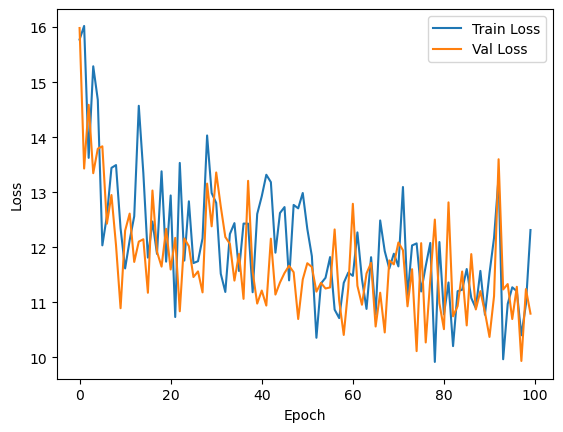

In [ ]:
epoch = np.arange(0, len(model.train_loss))

plt.plot(epoch, np.array(model.train_loss)/data.shape[1], label='Train Loss')
plt.plot(epoch, np.array(model.val_loss)/val_data.shape[1], label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [36]:
condition_mask = torch.zeros(nodes_max)

In [37]:
s = model.sample(data=torch.tensor([]),condition_mask=condition_mask, num_samples=10000, device="cuda:6")

100%|██████████| 1/1 [00:08<00:00,  8.13s/it]


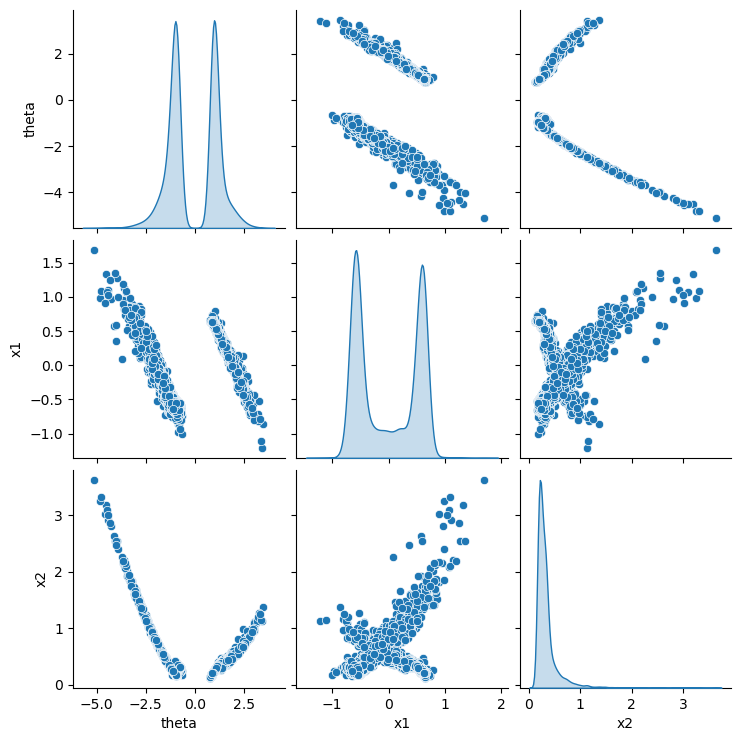

In [38]:
df = pd.DataFrame(s[0].cpu().numpy(), columns=['theta', 'x1', 'x2'])
sns.pairplot(df, diag_kind='kde')
plt.show()

In [30]:
s

tensor([[[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]]], device='cuda:6')